In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from model.regression import *
from train_regression import *

import math
import wandb
import torch
import torchaudio
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from easydict import EasyDict

device = torch.device(f'cuda:1' if torch.cuda.is_available() else 'cpu')

In [3]:
def load_model(uuid):
    api = wandb.Api()
    runs = api.runs('yermandy/vehicle-audio-nn', per_page=1000, order='config.uuid')

    for run in runs: 
        if run.name == str(uuid):
            params = EasyDict(run.config)
            params.val_loss_best = run.summary['val loss best']
            break
            
    split_indices = get_split_indices(params)
    
    model = ResNet18().to(device)
    weights = torch.load(f'weights/regression/model_{uuid}_diff.pth', device)
    model.load_state_dict(weights)
    return model, params


def plot_nn_outputs(T, E, results):
    # results = np.convolve(results, np.ones(3), 'valid')

    fig, ax1 = plt.subplots(figsize=(60, 6))
    ax2 = ax1.twinx()
    ax1.plot(T, results)
    ax1.hlines(1.0, T[0], T[-1], color='k', linestyle='--', linewidth=1.0)
    ax1.hlines(2.0, T[0], T[-1], color='k', linestyle='--', linewidth=1.0)

    for event in E:
        ax2.vlines(event, 0, 1, color='r', linewidth=1.0)
     
    
def plot_nn_cumsum(T, E, results):
    cumsum = np.cumsum(results)

    fig, ax = plt.subplots(figsize=(60, 6))
    ax2 = ax.twinx()
    ax.plot(T, cumsum)
    ax.step(np.append(E, T[-1]), range(len(E) + 1));

    for event in E:
        ax2.vlines(event, 0, 1, color='r', linewidth=1.0)
        
def plot_nn_cumsum_2(T, E, results):
    cumsum = np.cumsum(results)
    cumstep = get_cumstep(T, E)

    print(f'diff: {np.abs(cumsum - cumstep).mean():.4f}')

    fig, ax = plt.subplots(figsize=(60, 6))
    ax2 = ax.twinx()
    ax.plot(T, cumsum)
    ax.step(T, cumstep);

    for event in E:
        ax2.vlines(event, 0, 1, color='r', linewidth=1.0)
        
def plot_events_density(loader):
    events_per_window = []
    for x, y in loader:
        y = y.numpy()
        events_per_window.extend(y)

    fig, ax = plt.subplots()
    labels, counts = np.unique(events_per_window, return_counts=True)
    print(counts)
    ax.bar(labels, counts, align='center')
    ax.set_xticks(labels);
    
def test(uuid, FROM_TIME, TILL_TIME):
    model, params = load_model(uuid)

    dataset = VehicleDataset(signal, events, start_time=FROM_TIME, end_time=TILL_TIME, seed=0, params=params)
    loader = DataLoader(dataset, batch_size=64)
    
    params.val = get_additional_params(
        signal, events, params, start_time=FROM_TIME, end_time=TILL_TIME
    )

    val_results = validate(model, dataset, params.val, tqdm=tqdm)
    
    return val_results, params, loader

In [4]:
signal = load_audio('data/audio/20190819-Kutna Hora-L4-out-MVI_0040.wav')
events = load_events('data/labels/20190819-Kutna Hora-L4-out-MVI_0040.txt')

In [26]:
uuid = 1628045576
FROM_TIME = 1 * 60
TILL_TIME = 25 * 60    

results, params, loader = test(uuid, FROM_TIME, TILL_TIME)

  0%|          | 0/479 [00:00<?, ?it/s]

In [12]:
x, y = next(iter(loader))
print(x.shape)

torch.Size([64, 1, 72, 3101])


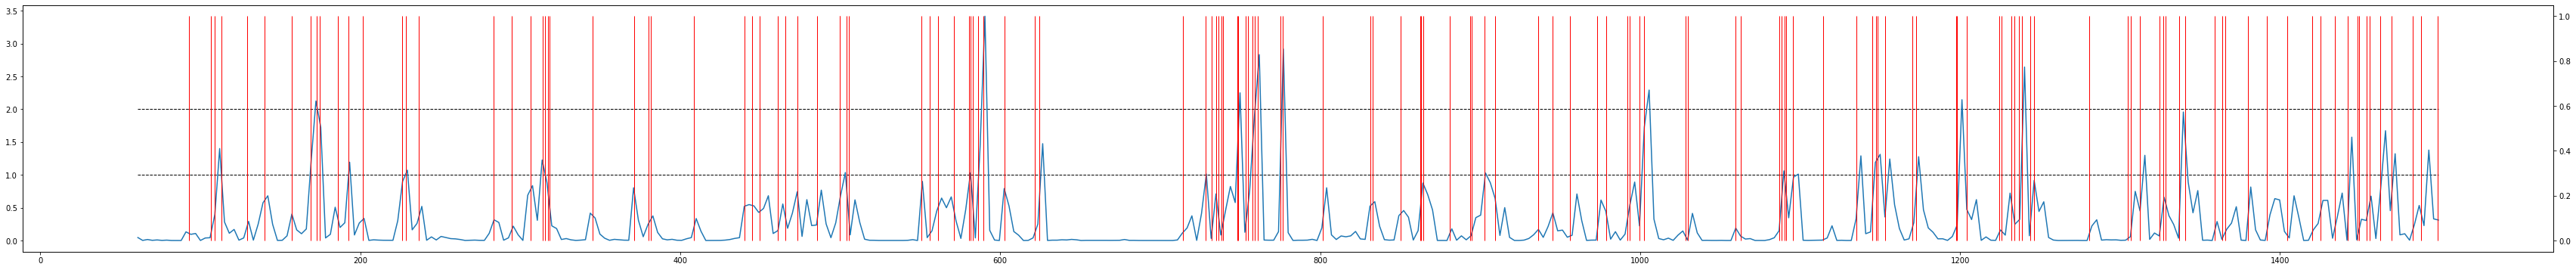

In [13]:
plot_nn_outputs(params.val.time, params.val.events, results)

diff: 2.7804


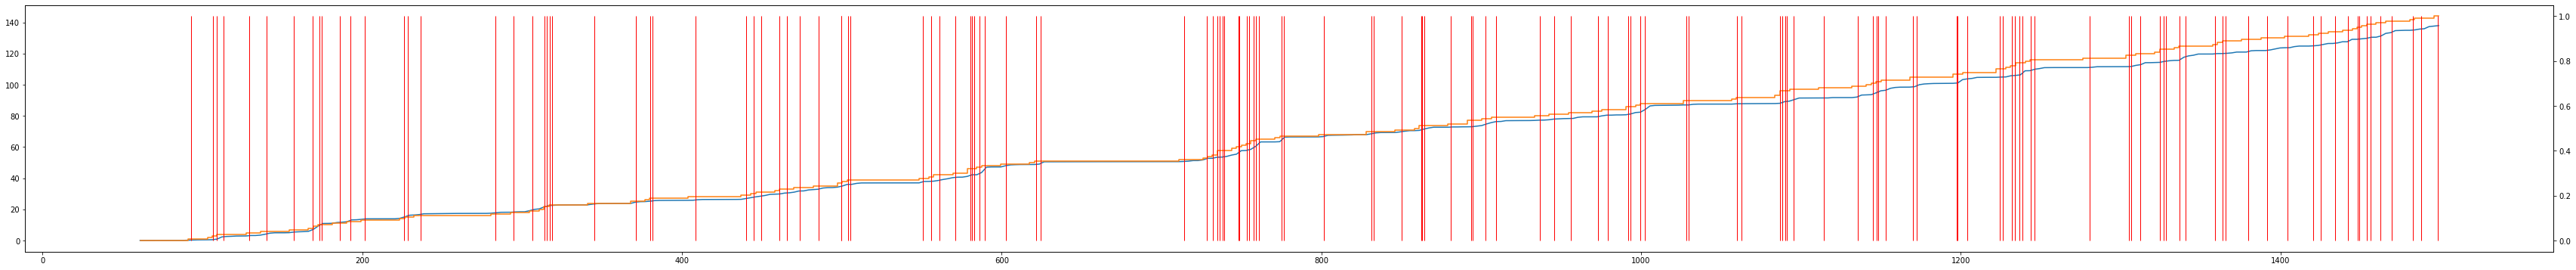

In [14]:
plot_nn_cumsum_2(params.val.time, params.val.events, results)

[87 48 27  7  4  1]


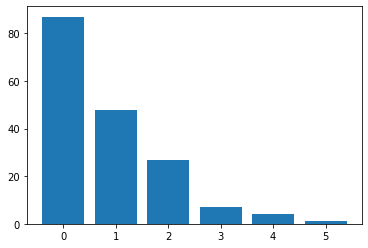

In [27]:
plot_events_density(loader)

In [24]:
# params

[124 104  20]


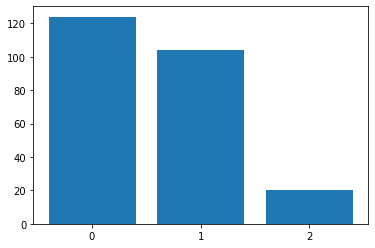

In [32]:
params.nn_hop_length = 3
params.frame_length = 3
params.n_frames = 1


dataset = VehicleDataset(signal, events, start_time=FROM_TIME, end_time=TILL_TIME, seed=0, params=params)
loader = DataLoader(dataset, batch_size=64)
plot_events_density(loader)

### Test all models

In [46]:
def test_model(params):
    global device
    model = ResNet18().to(device)
    weights = torch.load(f'weights/regression/model_{params.uuid}.pth', device)
    model.load_state_dict(weights)

    dataset = VehicleDataset(audio_file, labels_file, start_time=0, end_time=2, seed=0, params=params)
    
    K, E, T, results = test(model, dataset, params)
    
    cumsum = np.cumsum(results)
    cumstep = get_cumstep(T, E)
    
    val_loss = val_loss_best[str(params.uuid)]
    diff = np.abs(cumsum - cumstep).mean()
    diff2 = np.abs(cumsum[-1] - cumstep[-1])

    print('uuid:', params.uuid)
    print('val loss:', val_loss)
    print('diff:', diff)
    print('diff2:', diff2)
    print()
    
    fig, ax = plt.subplots(figsize=(60, 6))
    ax2 = ax.twinx()
    plt.title(f'{params.uuid} : window_length: {params.window_length}, frame_length: {params.frame_length}, n_frames: {params.n_frames}')
    ax.plot(T, cumsum)
    ax.step(T, cumstep);
    
#     plt.scatter(diff, diff2)
    

all: 0 | positive: 0


  0%|          | 0/180 [00:00<?, ?it/s]

uuid: 1627583476
val loss: 22.3371000289917
diff: 2.8434600929057017
diff2: 6.9367071823216975

all: 0 | positive: 0


  0%|          | 0/360 [00:00<?, ?it/s]

uuid: 1627587722
val loss: 28.369439840316772
diff: 1.8164846691716876
diff2: 0.0371883325278759

all: 0 | positive: 0


  0%|          | 0/180 [00:00<?, ?it/s]

uuid: 1627585494
val loss: 22.293153524398804
diff: 4.002150724828243
diff2: 11.905976109206676

all: 0 | positive: 0


  0%|          | 0/360 [00:00<?, ?it/s]

uuid: 1627589910
val loss: 25.666179299354553
diff: 1.2373106399525164
diff2: 1.9082877496257424

all: 0 | positive: 0


  0%|          | 0/360 [00:00<?, ?it/s]

uuid: 1627592207
val loss: 27.403814792633057
diff: 1.5901002467661682
diff2: 5.205990759655833

all: 0 | positive: 0


  0%|          | 0/270 [00:00<?, ?it/s]

uuid: 1627594618
val loss: 28.12509799003601
diff: 1.2889739788792751
diff2: 2.574916385114193

all: 0 | positive: 0


  0%|          | 0/270 [00:00<?, ?it/s]

uuid: 1627596636
val loss: 26.889333486557007
diff: 1.5852518361130798
diff2: 2.0382854901254177

all: 0 | positive: 0


  0%|          | 0/216 [00:00<?, ?it/s]

uuid: 1627601120
val loss: 27.492205142974857
diff: 1.2629815512509257
diff2: 0.00014376454055309296

all: 0 | positive: 0


  0%|          | 0/270 [00:00<?, ?it/s]

uuid: 1627598804
val loss: 27.373661518096924
diff: 1.4588364823272935
diff2: 3.624551396816969

all: 0 | positive: 0


  0%|          | 0/216 [00:00<?, ?it/s]

uuid: 1627603051
val loss: 25.648295164108276
diff: 2.1255981538927666
diff2: 1.9118031188845634

all: 0 | positive: 0


  0%|          | 0/216 [00:00<?, ?it/s]

uuid: 1627605146
val loss: 28.45936894416809
diff: 2.523879511773379
diff2: 3.7929745223373175

all: 0 | positive: 0


  0%|          | 0/180 [00:00<?, ?it/s]

uuid: 1627607416
val loss: 27.65303683280945
diff: 1.8601478525540895
diff2: 5.996704768389463

all: 0 | positive: 0


  0%|          | 0/180 [00:00<?, ?it/s]

uuid: 1627609516
val loss: 27.396083116531372
diff: 2.382172877031068
diff2: 2.6984198689460754

all: 0 | positive: 0


  0%|          | 0/180 [00:00<?, ?it/s]

uuid: 1627611887
val loss: 27.41121244430542
diff: 2.485107025762813
diff2: 6.066206991672516

all: 0 | positive: 0


  0%|          | 0/360 [00:00<?, ?it/s]

uuid: 1627614520
val loss: 24.9681795835495
diff: 1.0917306722348763
diff2: 0.8339763674885035

all: 0 | positive: 0


  0%|          | 0/360 [00:00<?, ?it/s]

uuid: 1627616733
val loss: 24.1927547454834
diff: 1.2194993281064348
diff2: 1.7359639778733253

all: 0 | positive: 0


  0%|          | 0/360 [00:00<?, ?it/s]

uuid: 1627619058
val loss: 25.105775117874146
diff: 0.9724369269019614
diff2: 3.1912783263251185

all: 0 | positive: 0


  0%|          | 0/270 [00:00<?, ?it/s]

uuid: 1627621519
val loss: 22.074549436569217
diff: 1.0333580770081392
diff2: 1.8550525940954685

all: 0 | positive: 0


  0%|          | 0/270 [00:00<?, ?it/s]

uuid: 1627623603
val loss: 25.458259999752045
diff: 1.2454826580015597
diff2: 0.46032524667680264

all: 0 | positive: 0


  0%|          | 0/270 [00:00<?, ?it/s]

uuid: 1627625820
val loss: 21.43829655647278
diff: 1.7772711907789387
diff2: 3.6528399735689163

all: 0 | positive: 0


  0%|          | 0/216 [00:00<?, ?it/s]

uuid: 1627628176
val loss: 21.649101614952087
diff: 1.1359752085818737
diff2: 2.9604315757751465



/tmp/ipykernel_3565319/3979339882.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(60, 6))


all: 0 | positive: 0


  0%|          | 0/216 [00:00<?, ?it/s]

uuid: 1627630169
val loss: 28.7886643409729
diff: 1.9037535428586934
diff2: 4.228295166045427

all: 0 | positive: 0


  0%|          | 0/360 [00:00<?, ?it/s]

uuid: 1627563368
val loss: 21.086644649505615
diff: 1.365772879206472
diff2: 0.10633839853107929

all: 0 | positive: 0


  0%|          | 0/360 [00:00<?, ?it/s]

uuid: 1627565420
val loss: 21.749688625335693
diff: 1.4972143104455122
diff2: 0.05262525659054518

all: 0 | positive: 0


  0%|          | 0/360 [00:00<?, ?it/s]

uuid: 1627567553
val loss: 22.671743869781498
diff: 1.635725081210128
diff2: 1.576884115114808

all: 0 | positive: 0


  0%|          | 0/270 [00:00<?, ?it/s]

uuid: 1627569798
val loss: 20.829692840576172
diff: 1.2119464162047262
diff2: 0.5325105935335159

all: 0 | positive: 0


  0%|          | 0/270 [00:00<?, ?it/s]

uuid: 1627571654
val loss: 20.772055864334103
diff: 1.3826924143566026
diff2: 0.9976713880896568

all: 0 | positive: 0


  0%|          | 0/270 [00:00<?, ?it/s]

uuid: 1627573678
val loss: 24.49270534515381
diff: 2.1451102486501137
diff2: 4.989833811298013

all: 0 | positive: 0


  0%|          | 0/216 [00:00<?, ?it/s]

uuid: 1627575821
val loss: 23.188809633255005
diff: 1.43408437890725
diff2: 2.167257850058377

all: 0 | positive: 0


  0%|          | 0/216 [00:00<?, ?it/s]

uuid: 1627577614
val loss: 21.20389080047607
diff: 1.5858063283290162
diff2: 0.8389273509383202

all: 0 | positive: 0


  0%|          | 0/216 [00:00<?, ?it/s]

uuid: 1627579571
val loss: 21.12568688392639
diff: 2.1804047048057393
diff2: 3.575967237353325

all: 0 | positive: 0


  0%|          | 0/180 [00:00<?, ?it/s]

uuid: 1627581695
val loss: 20.871323108673096
diff: 1.821533756599658
diff2: 4.740063291043043



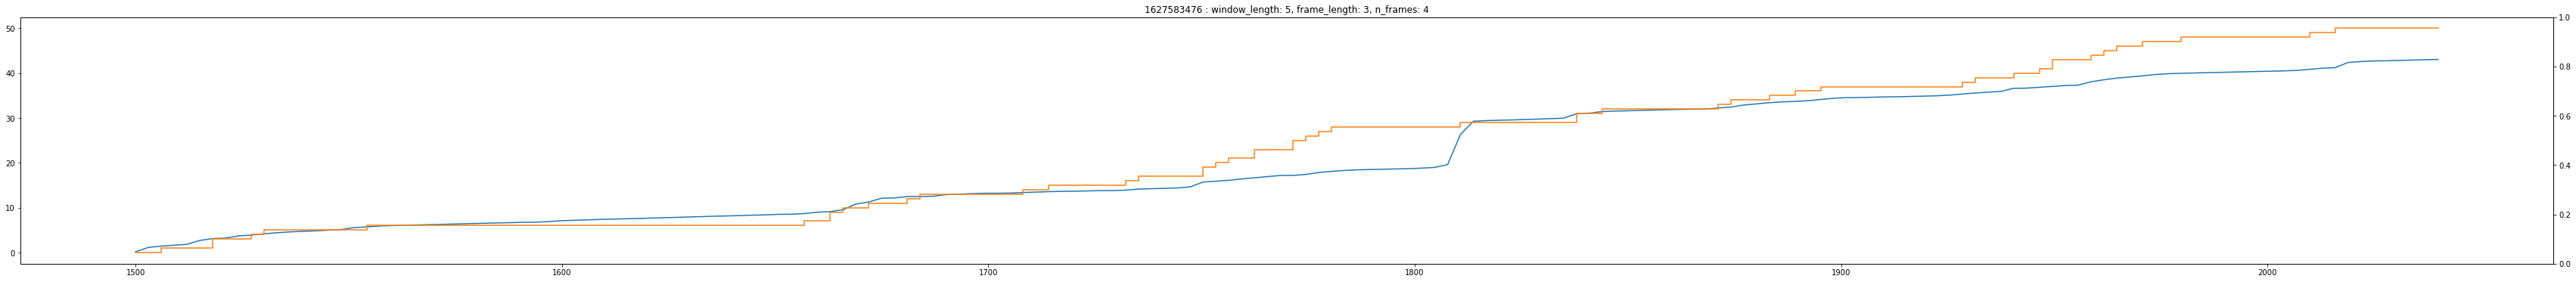

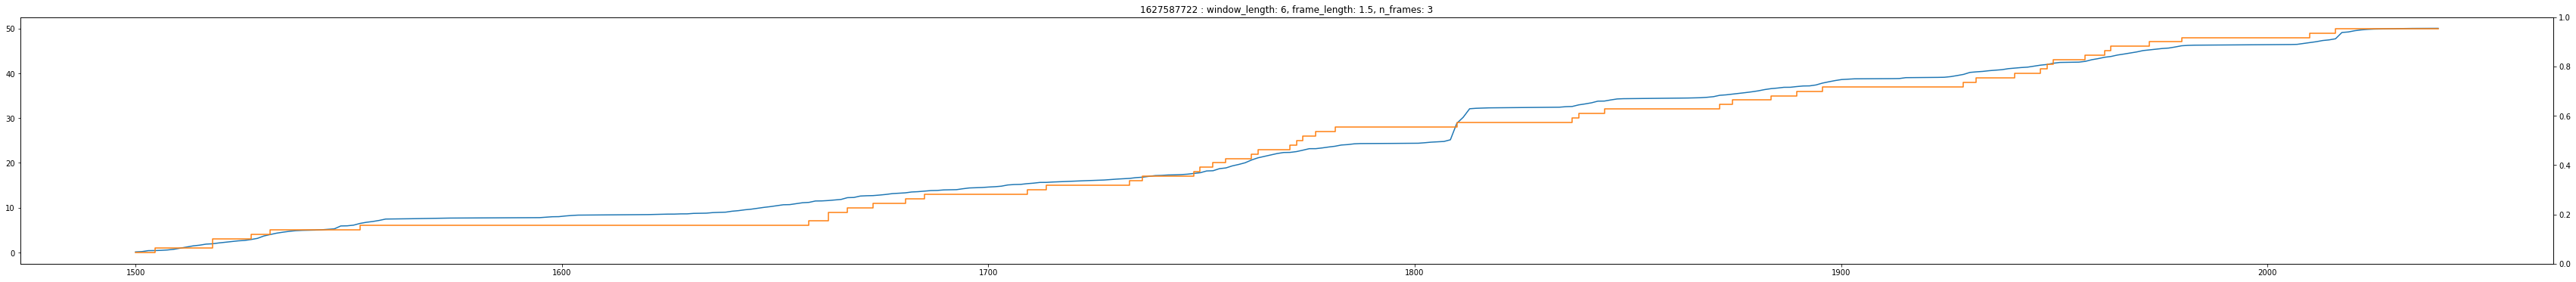

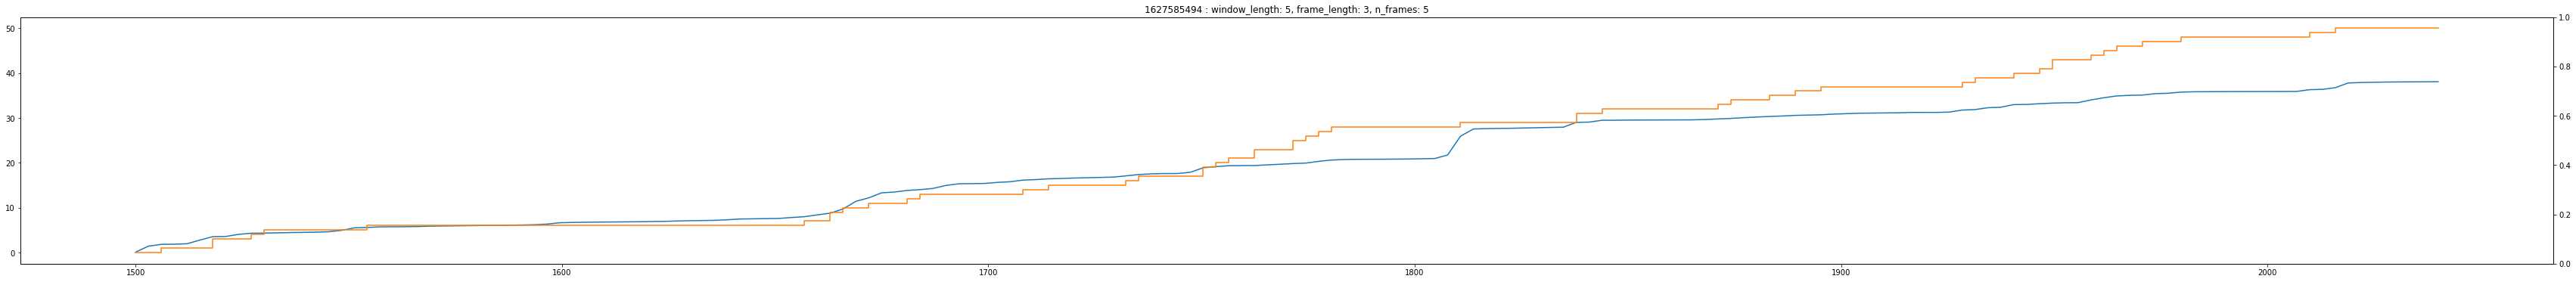

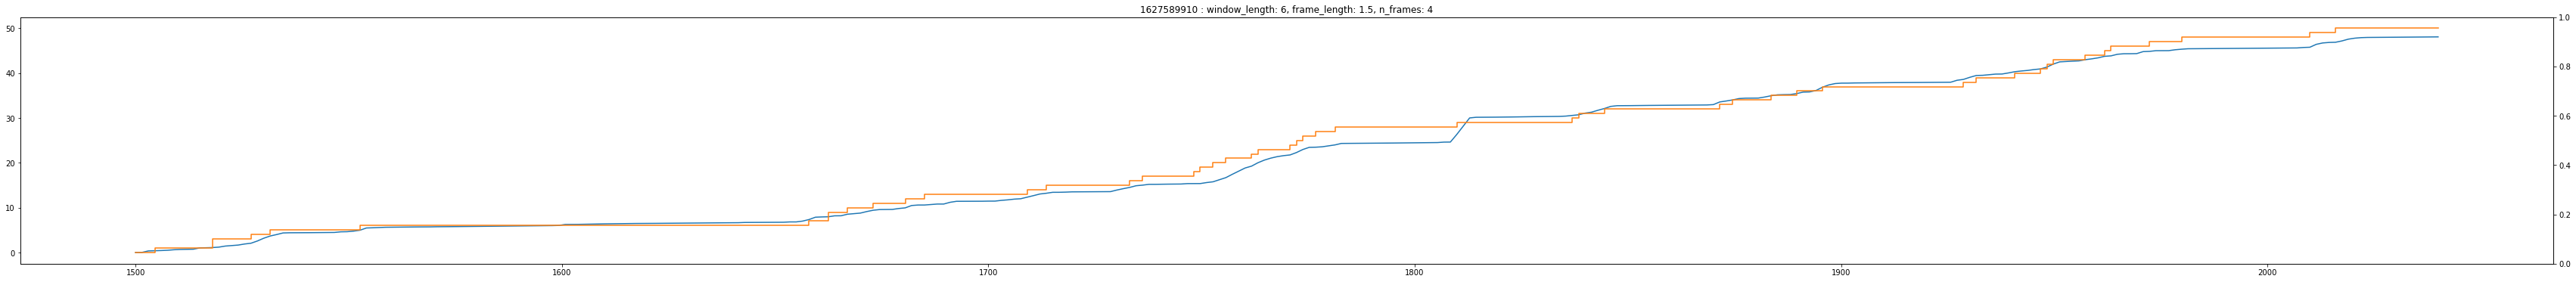

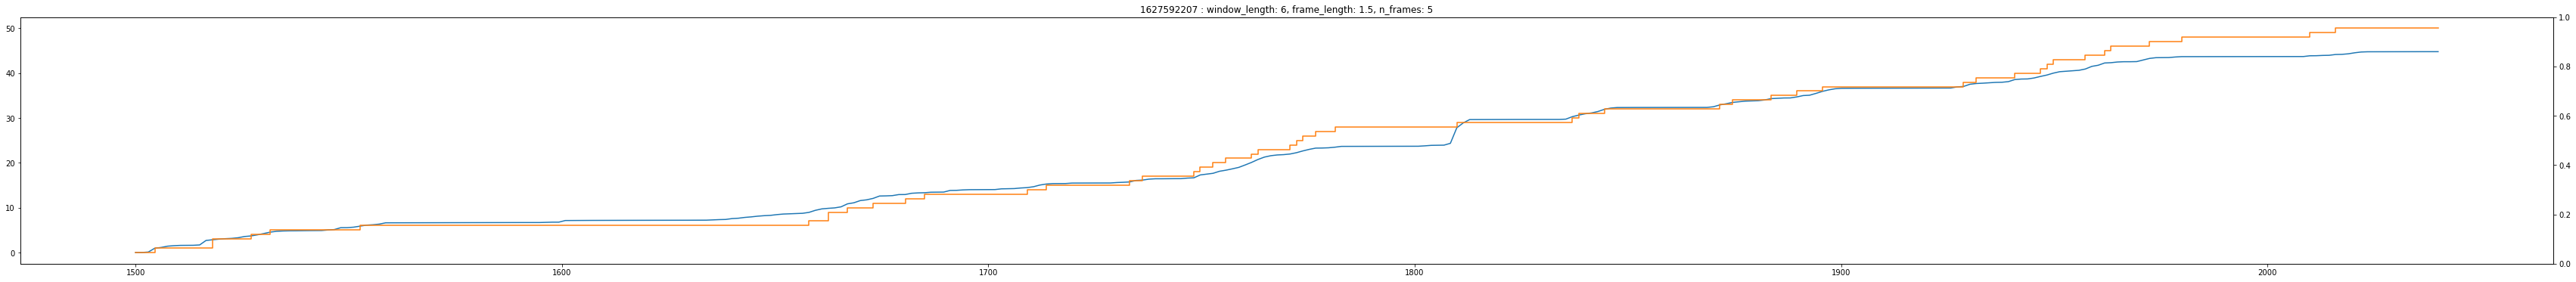

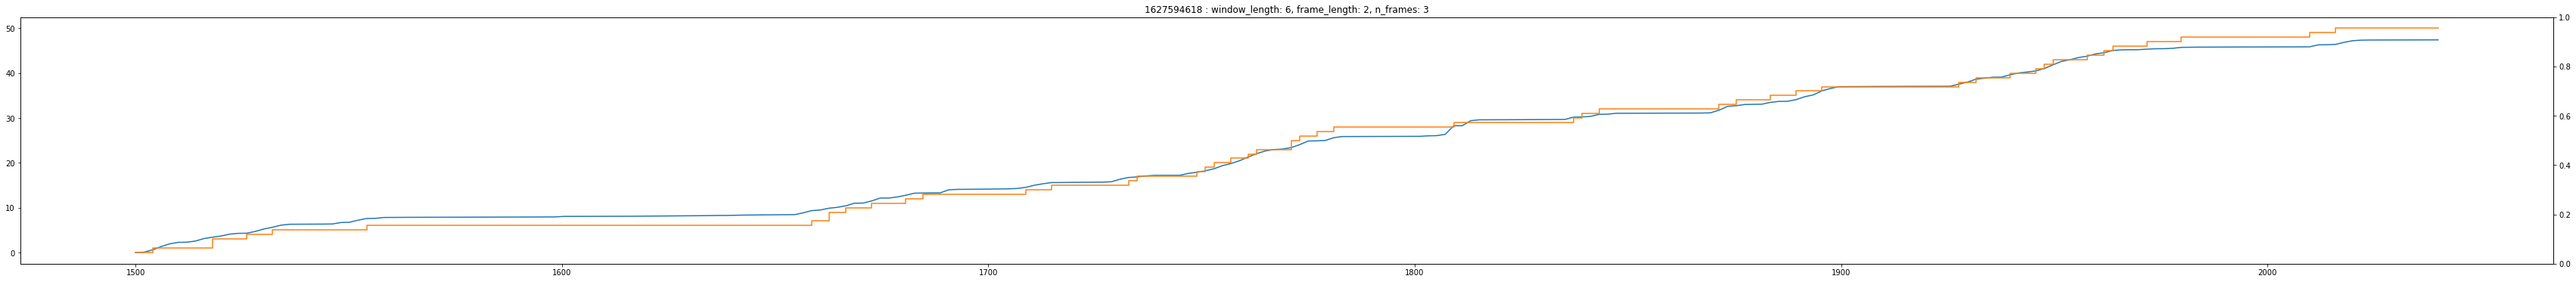

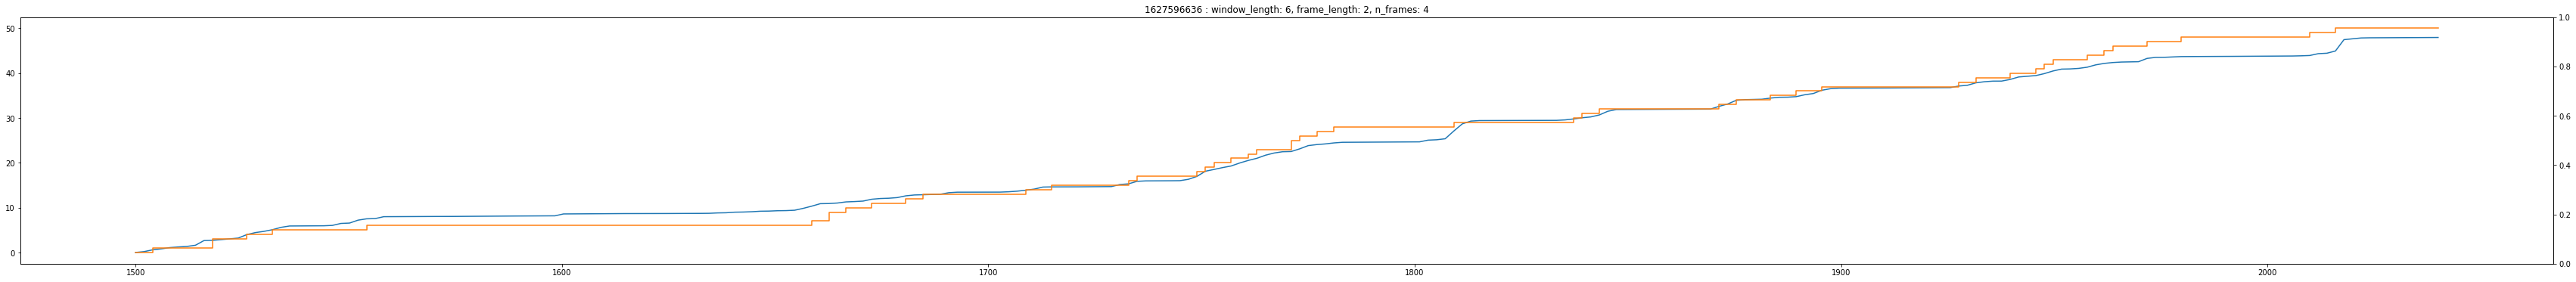

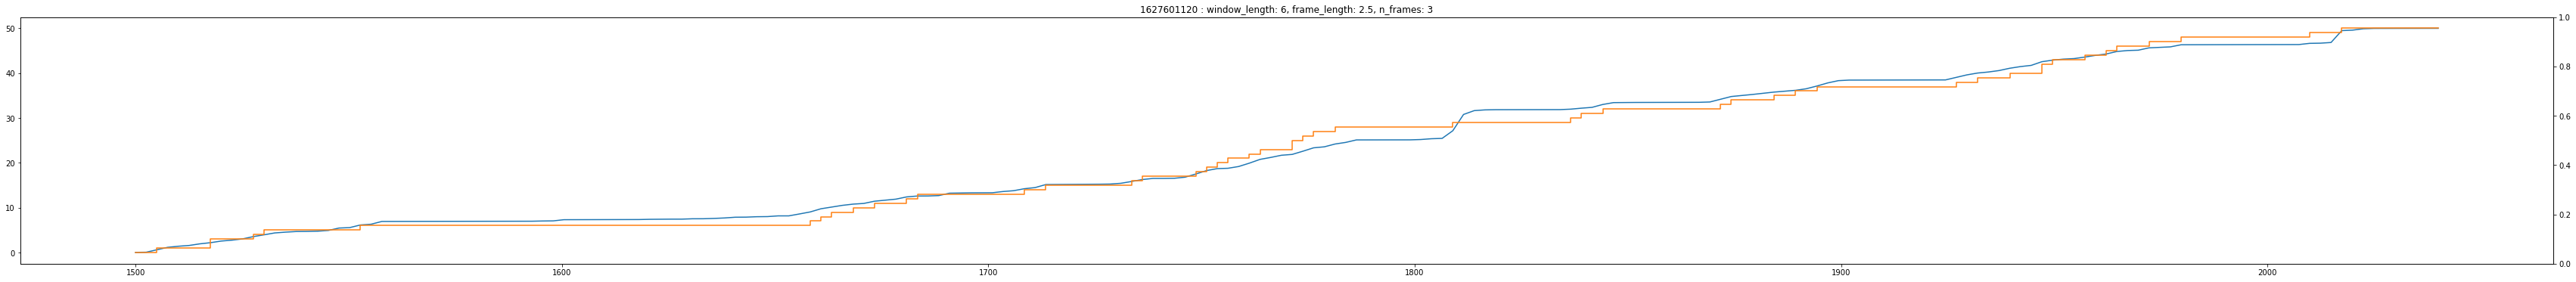

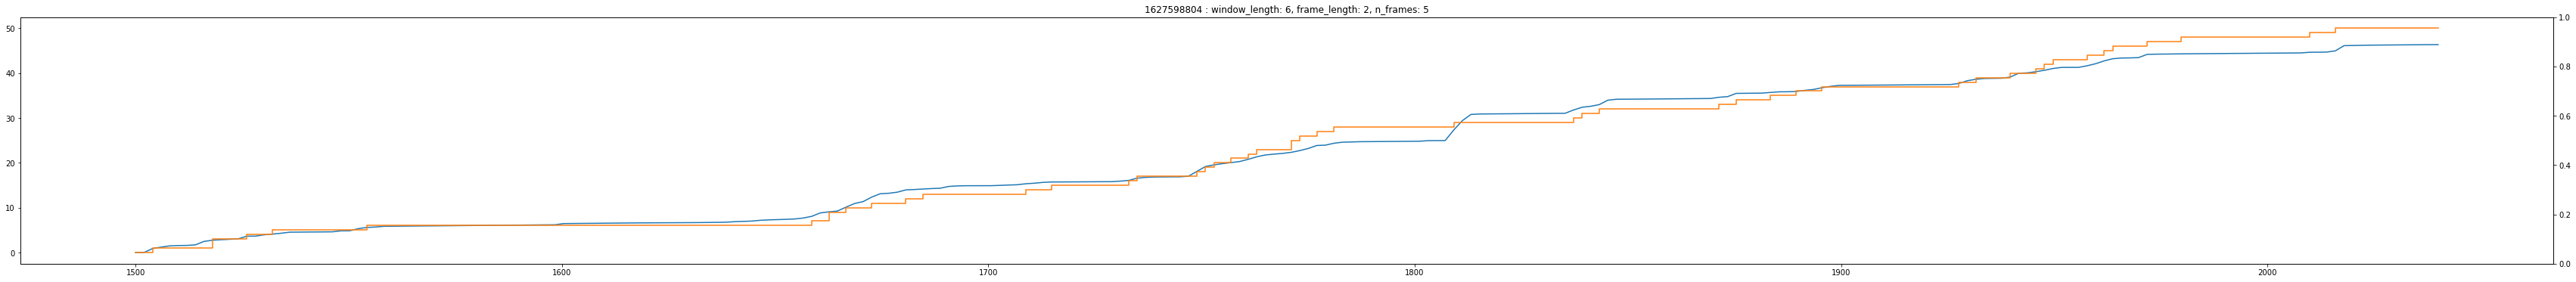

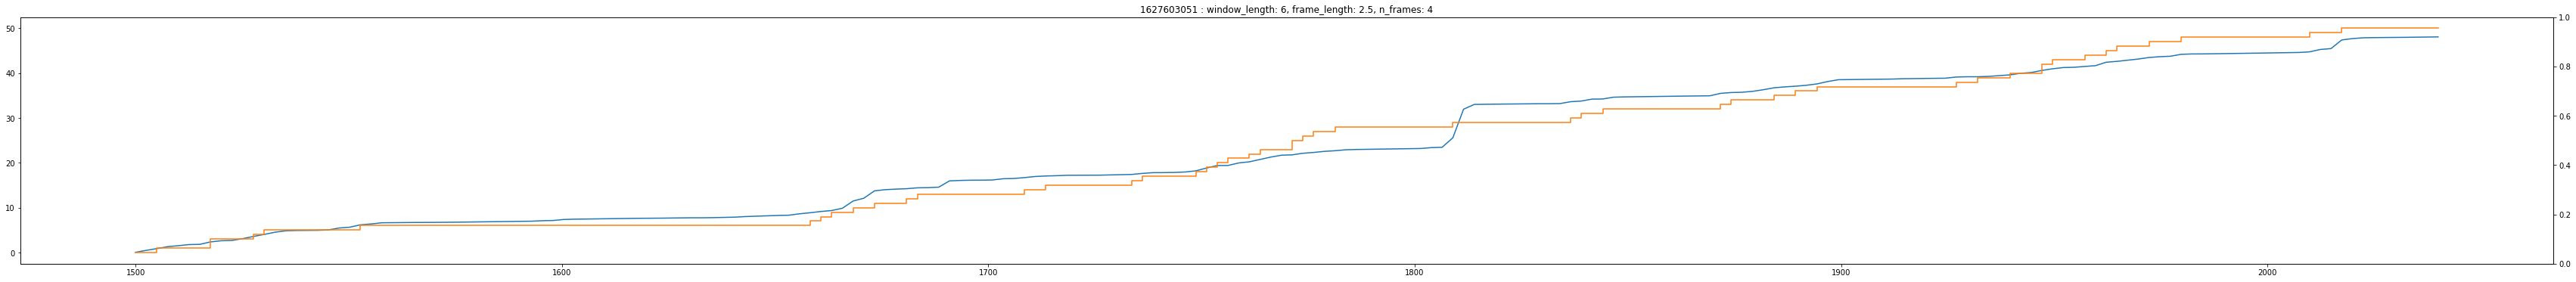

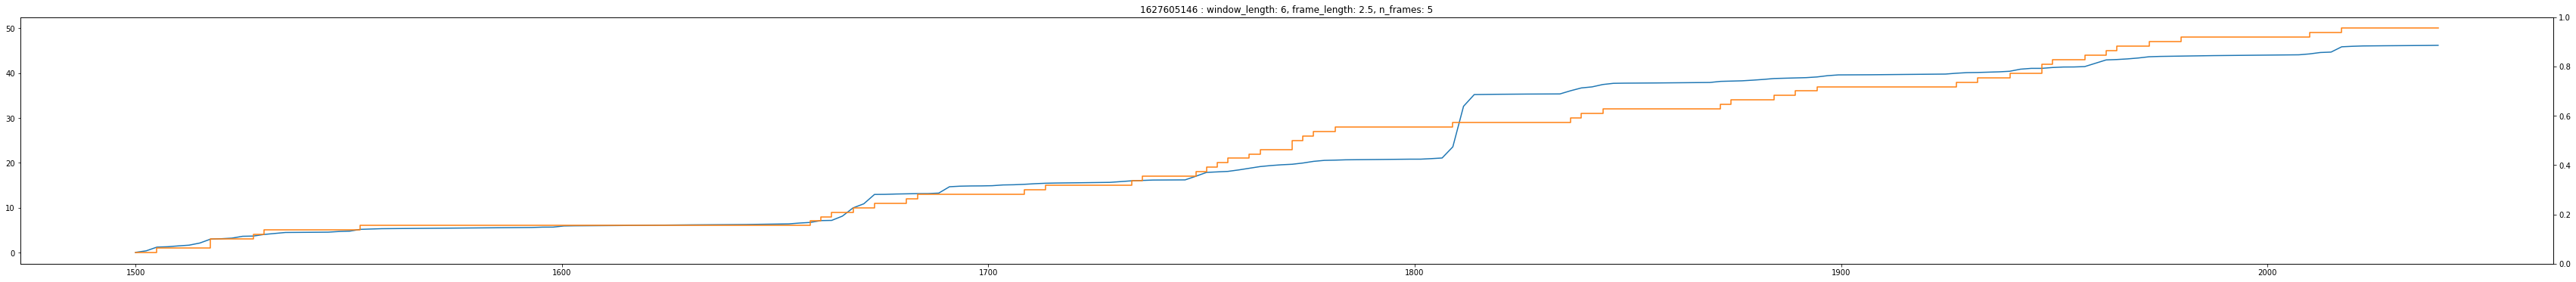

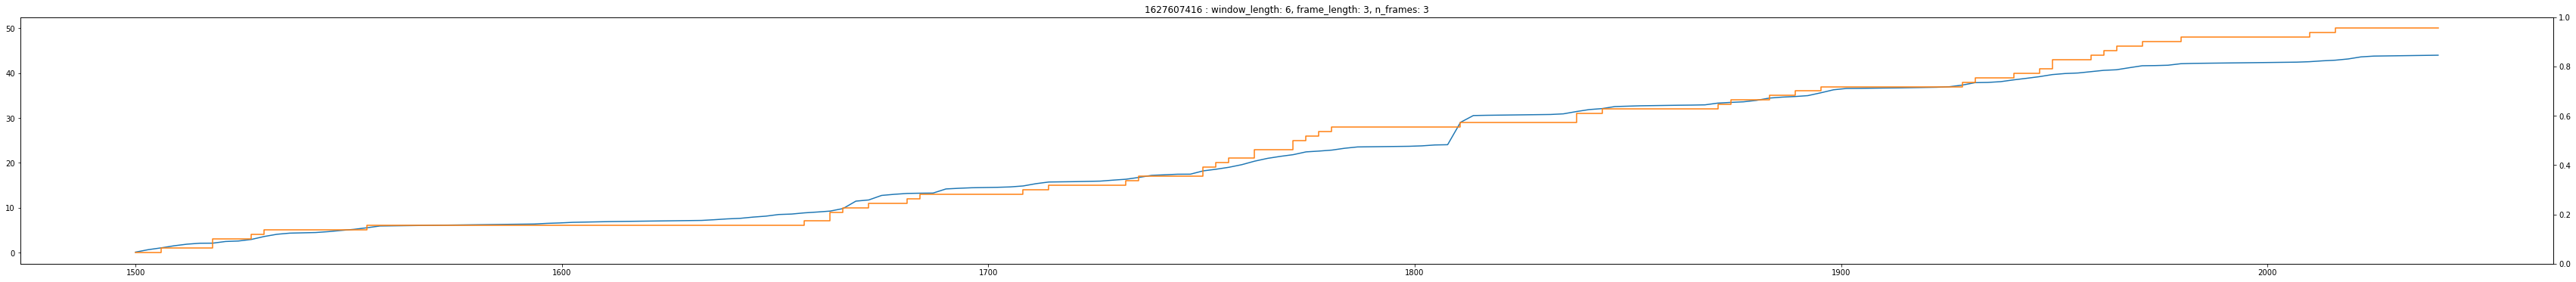

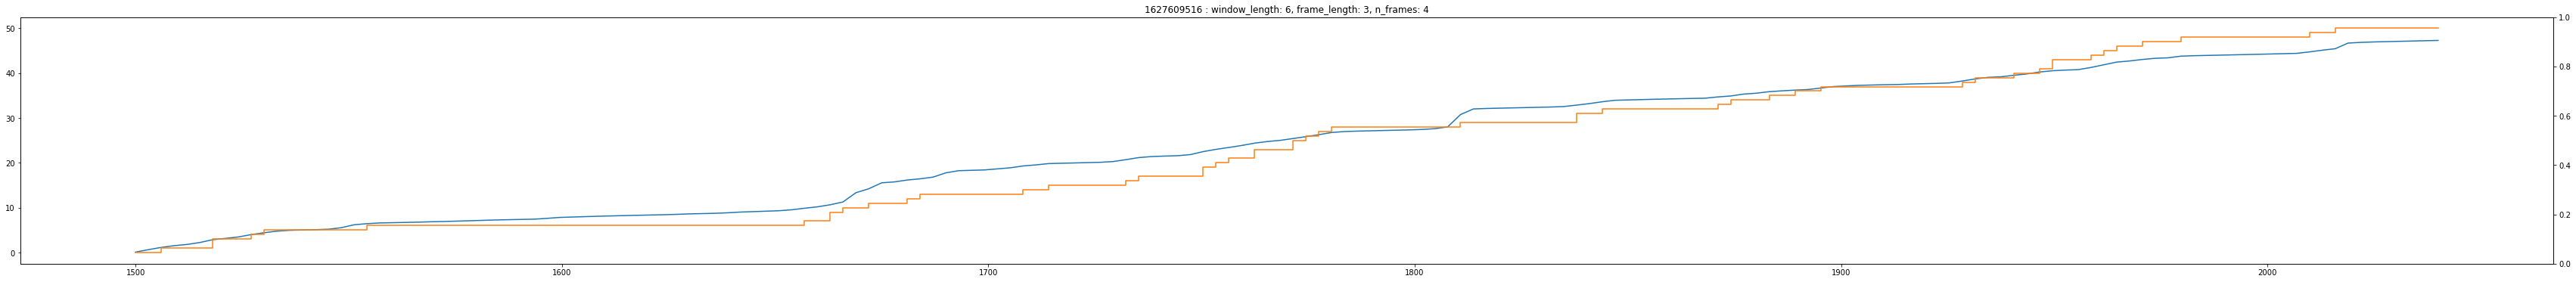

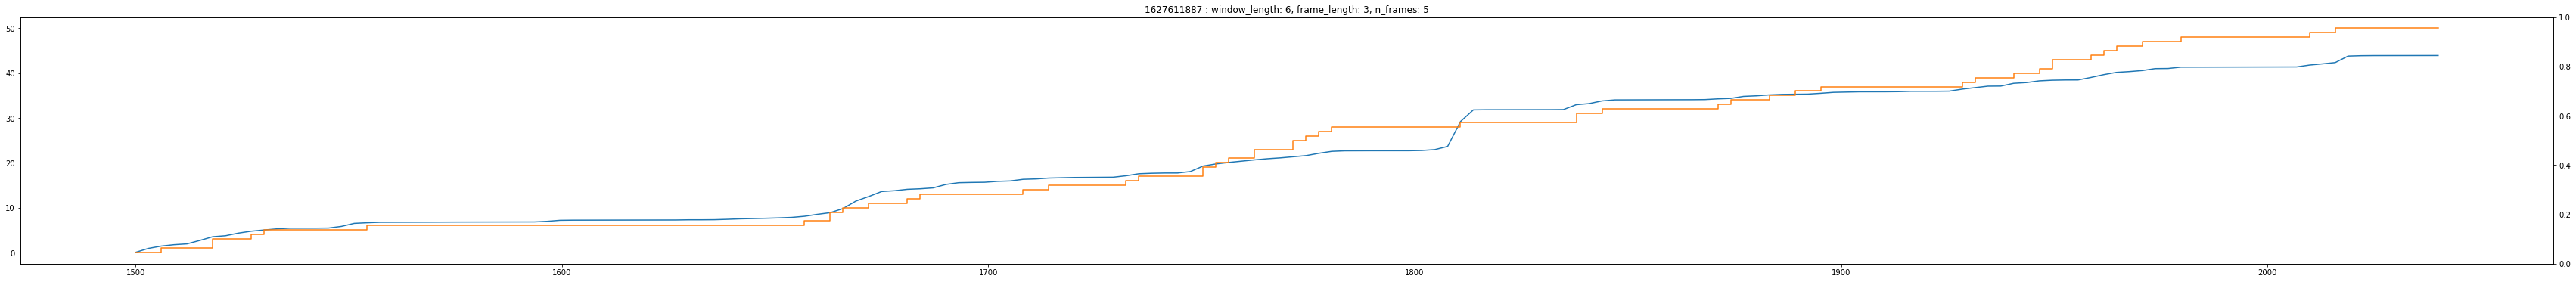

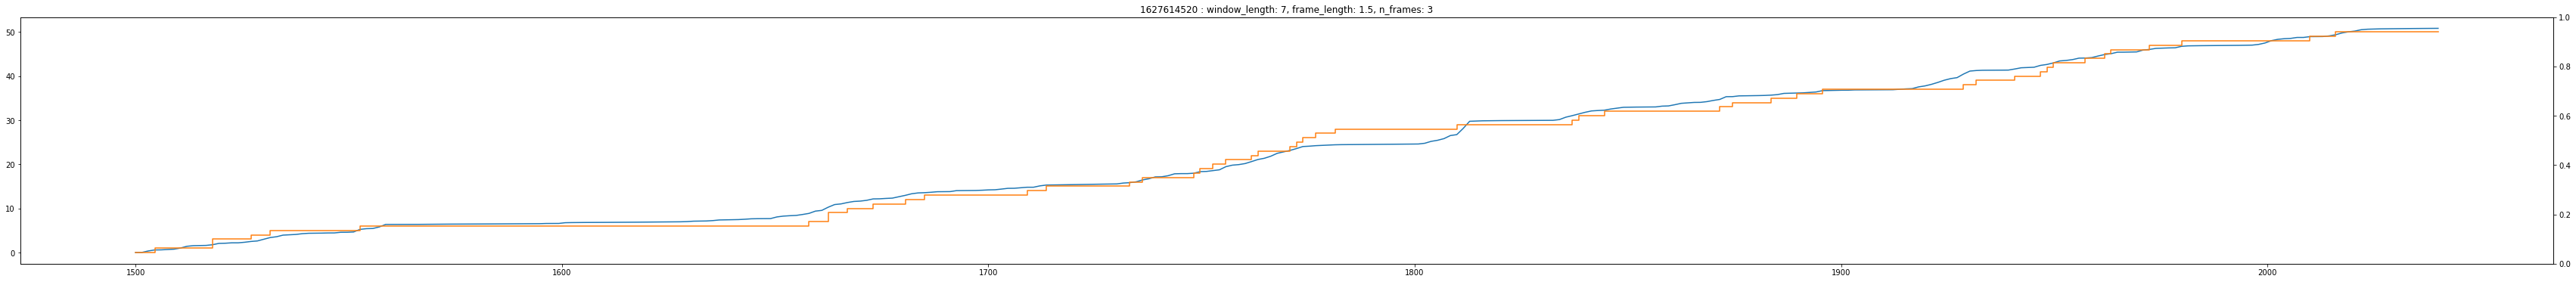

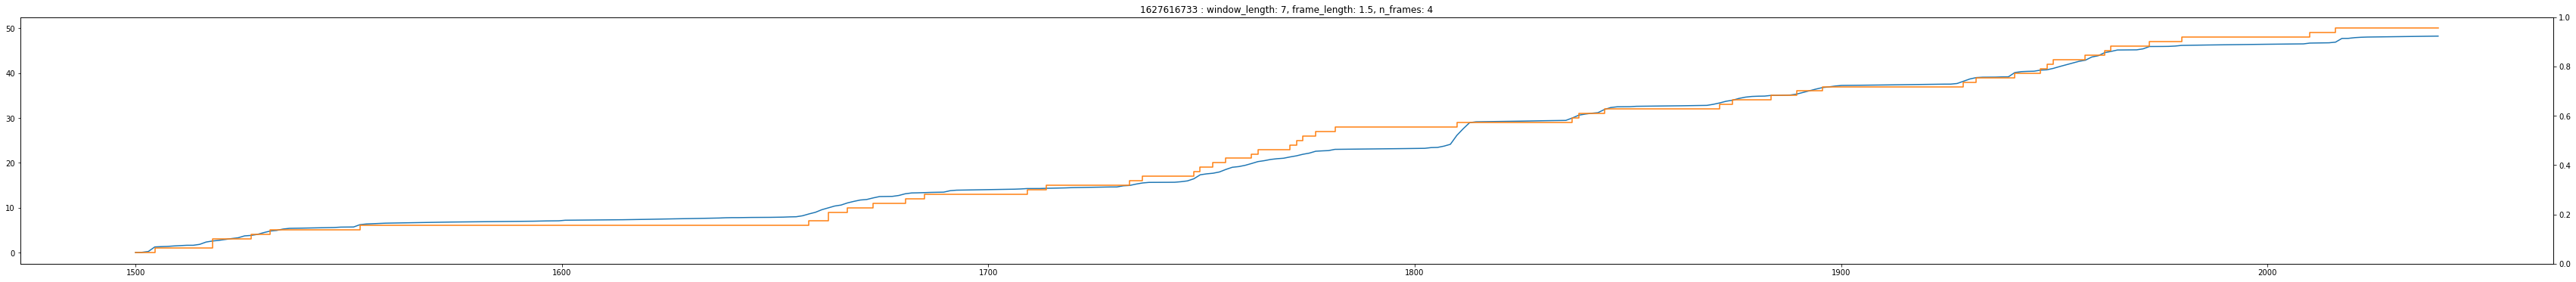

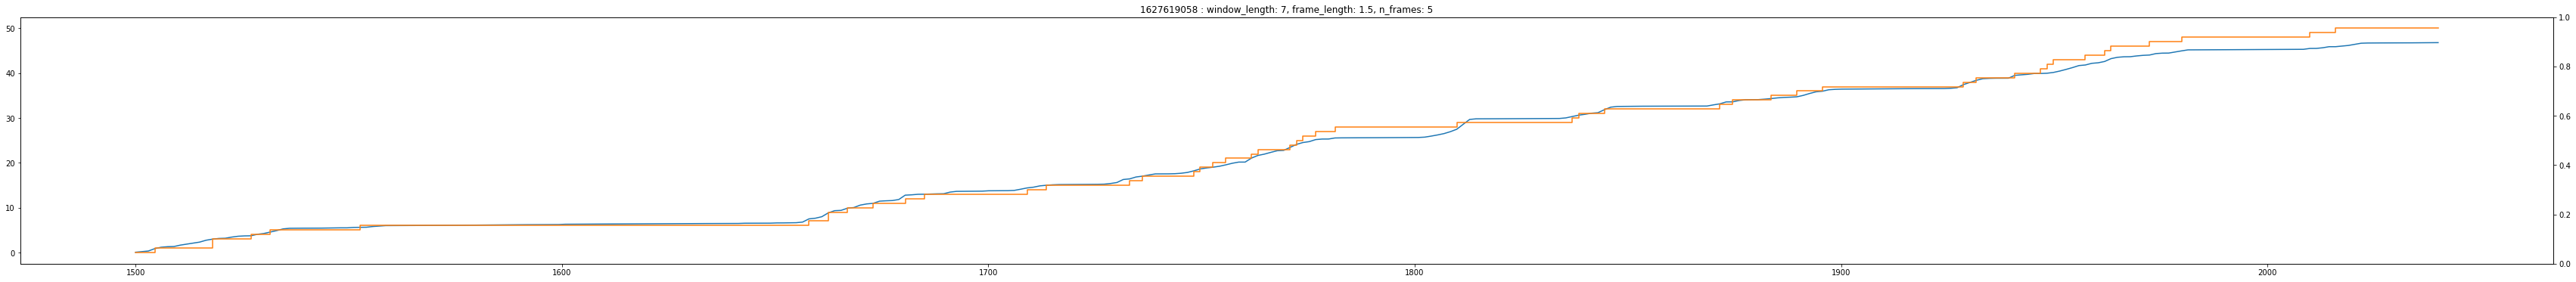

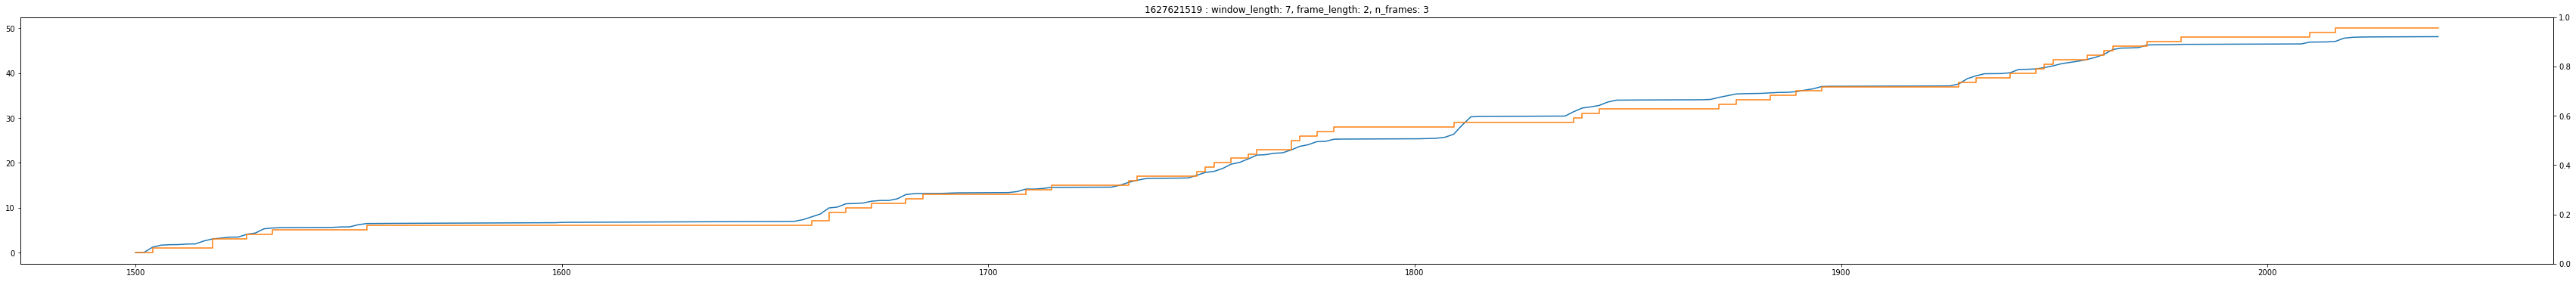

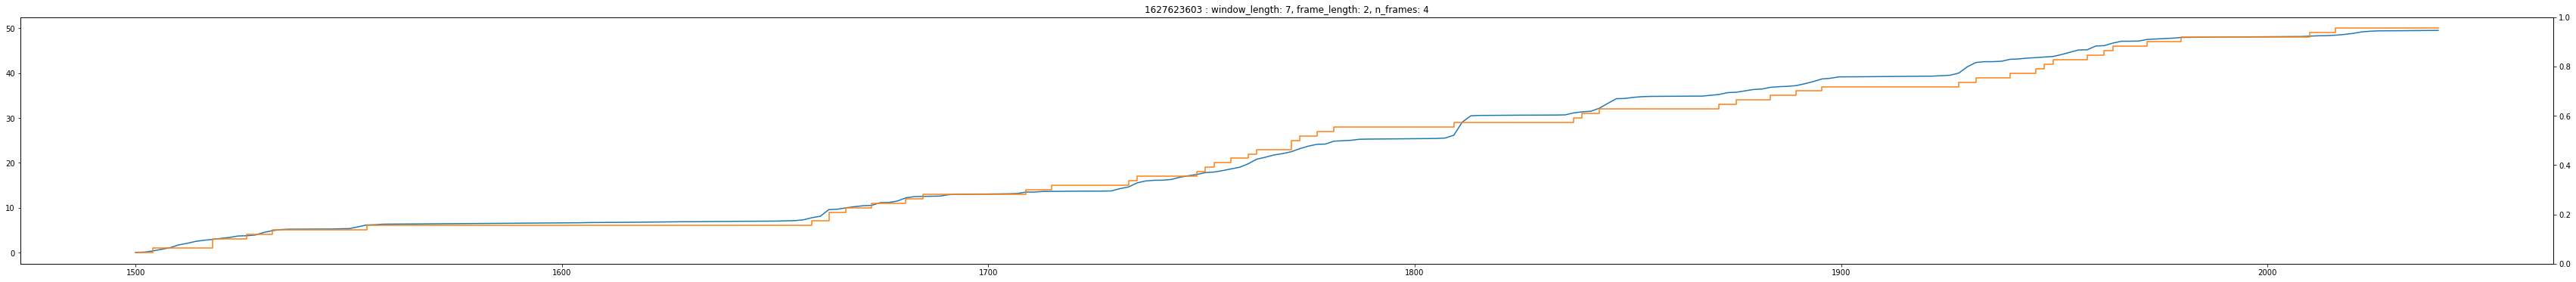

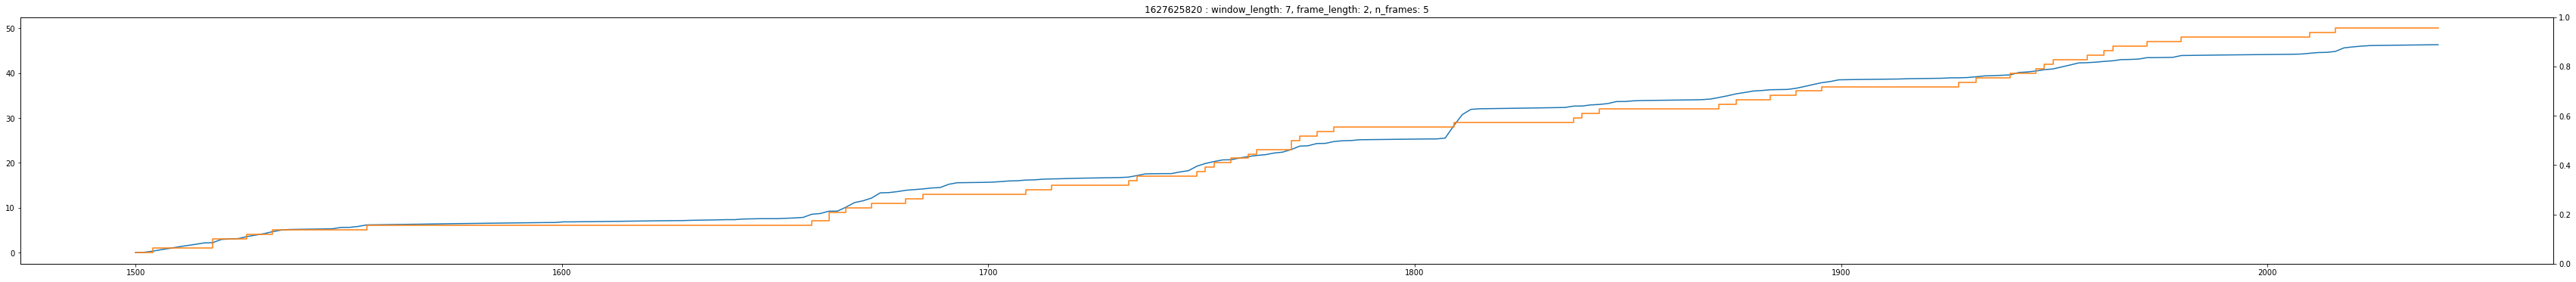

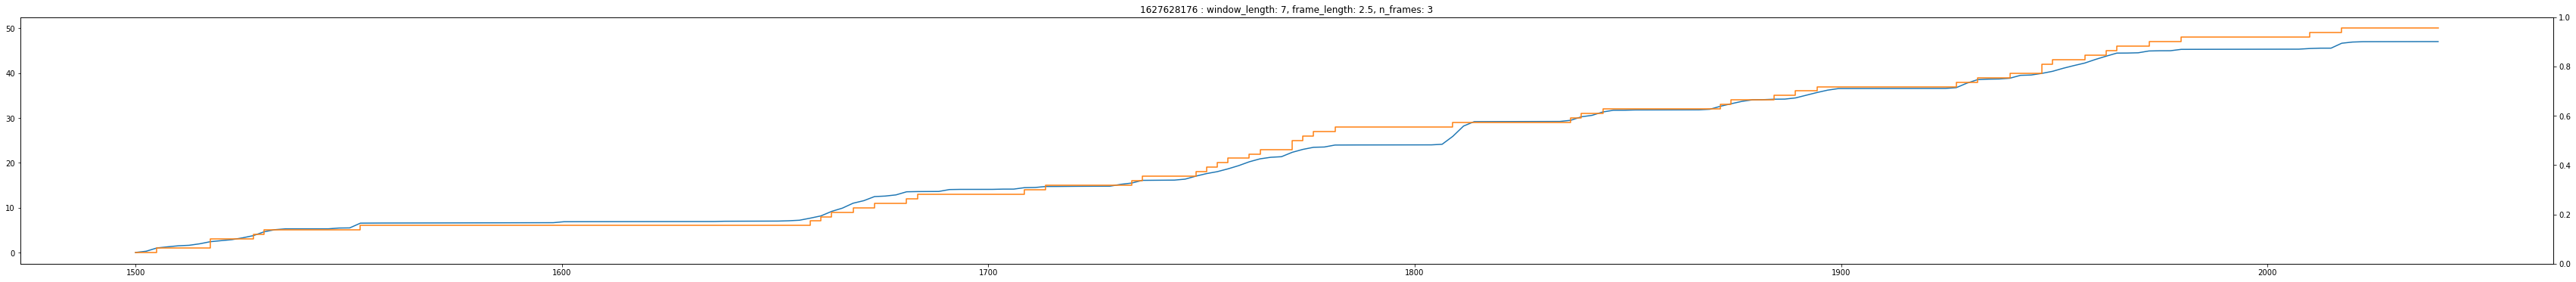

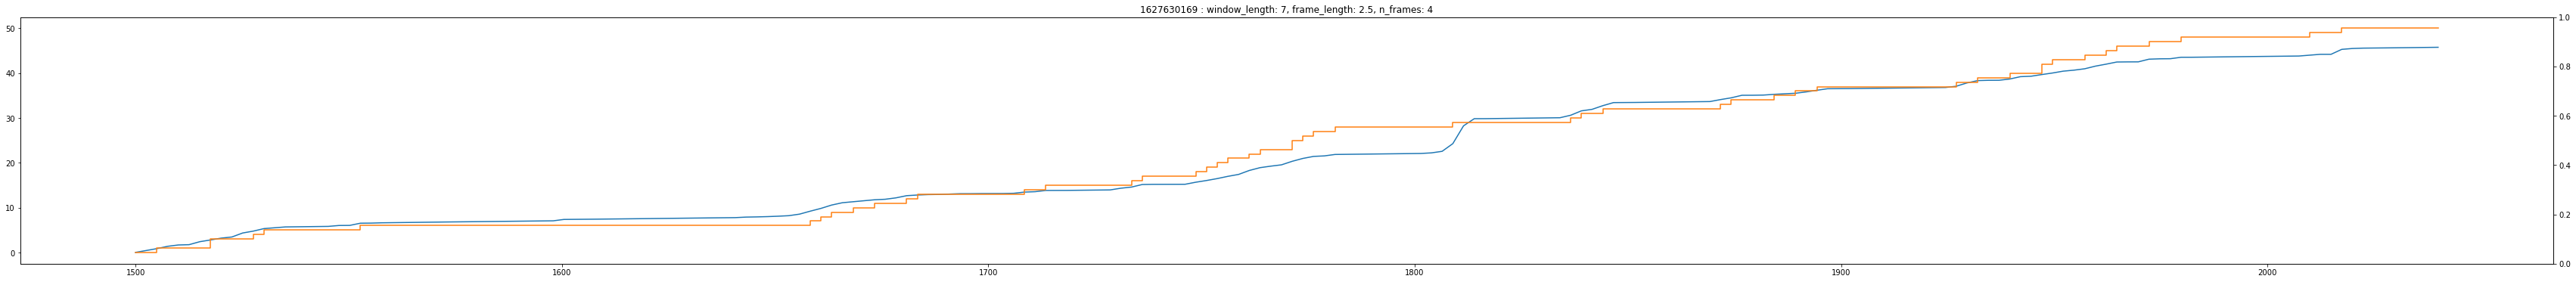

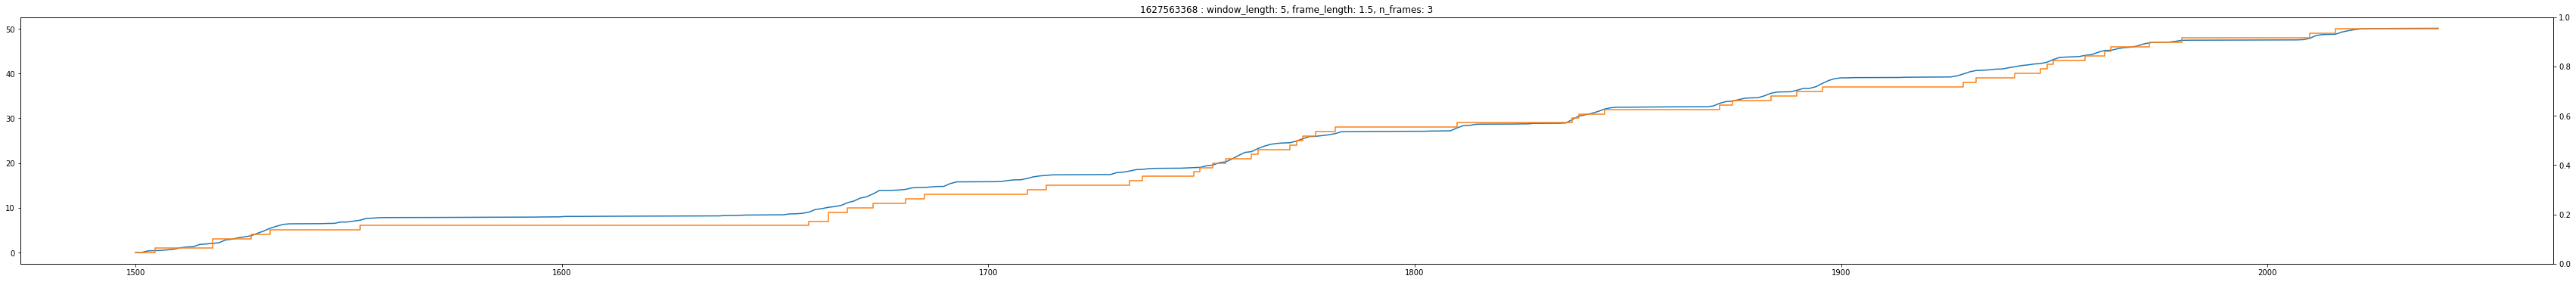

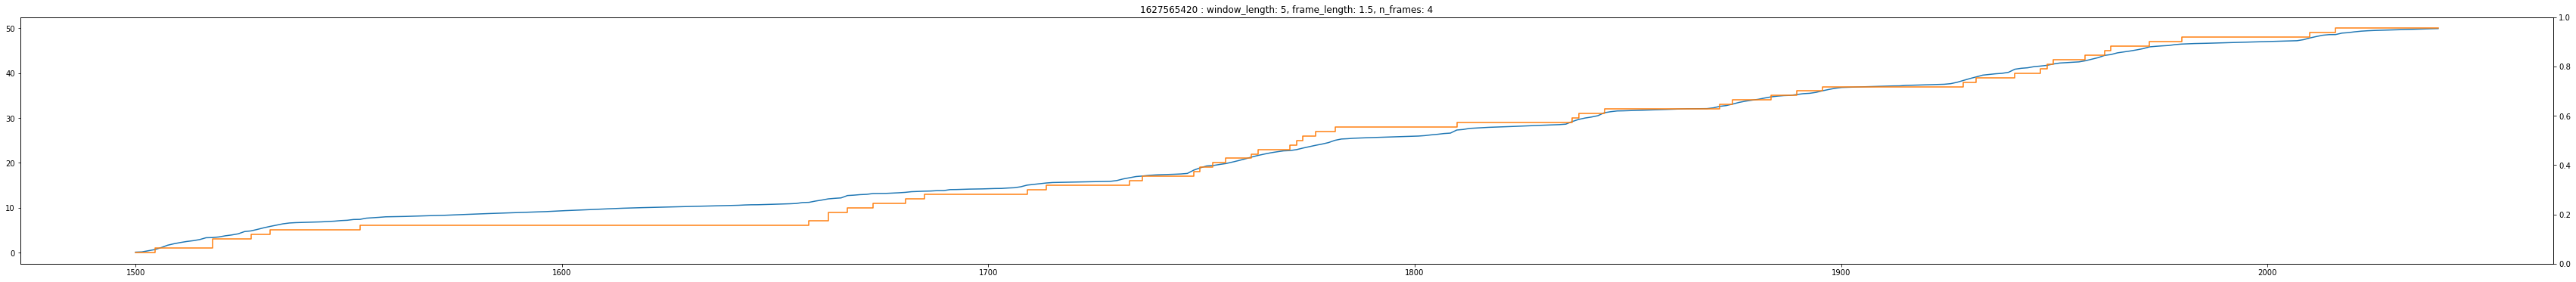

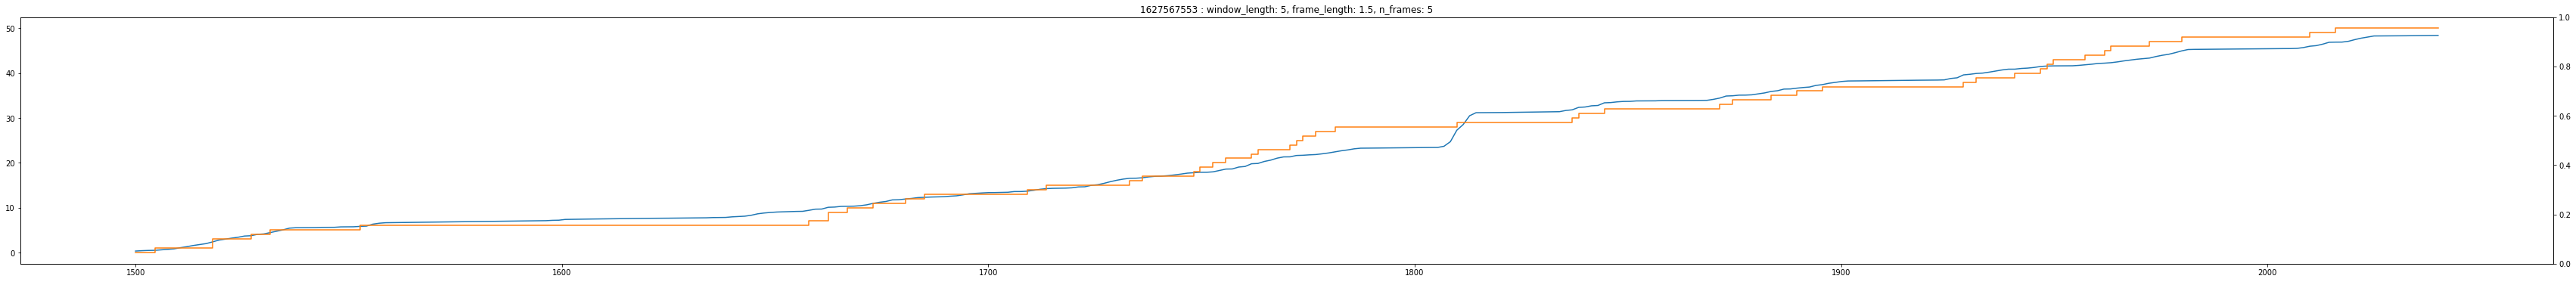

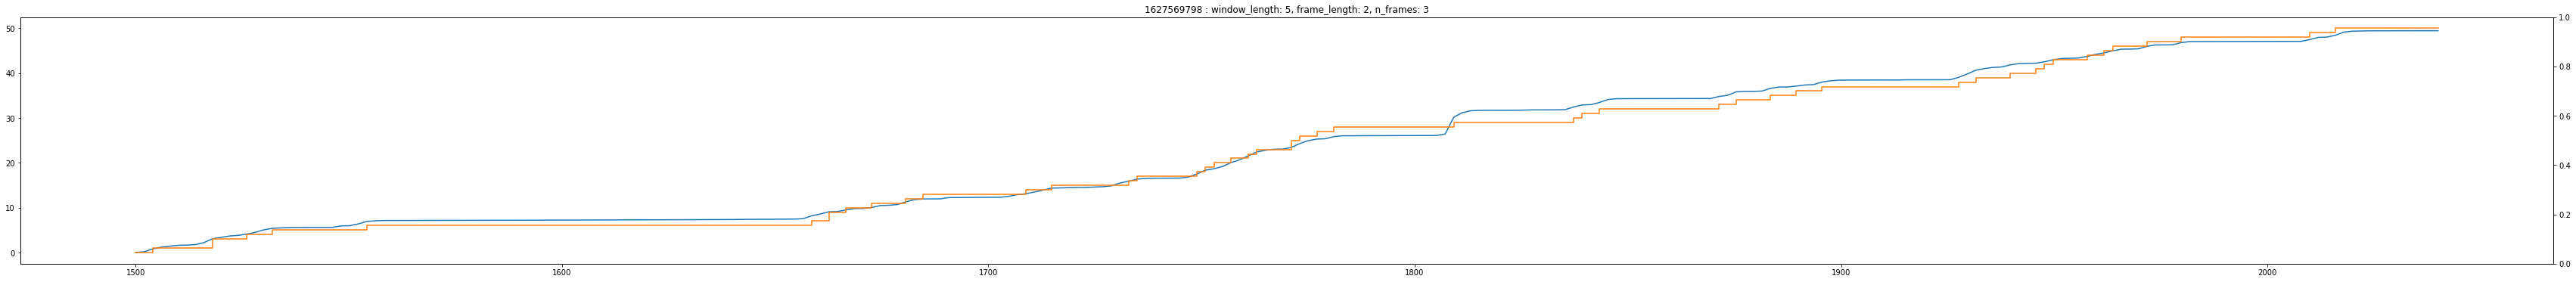

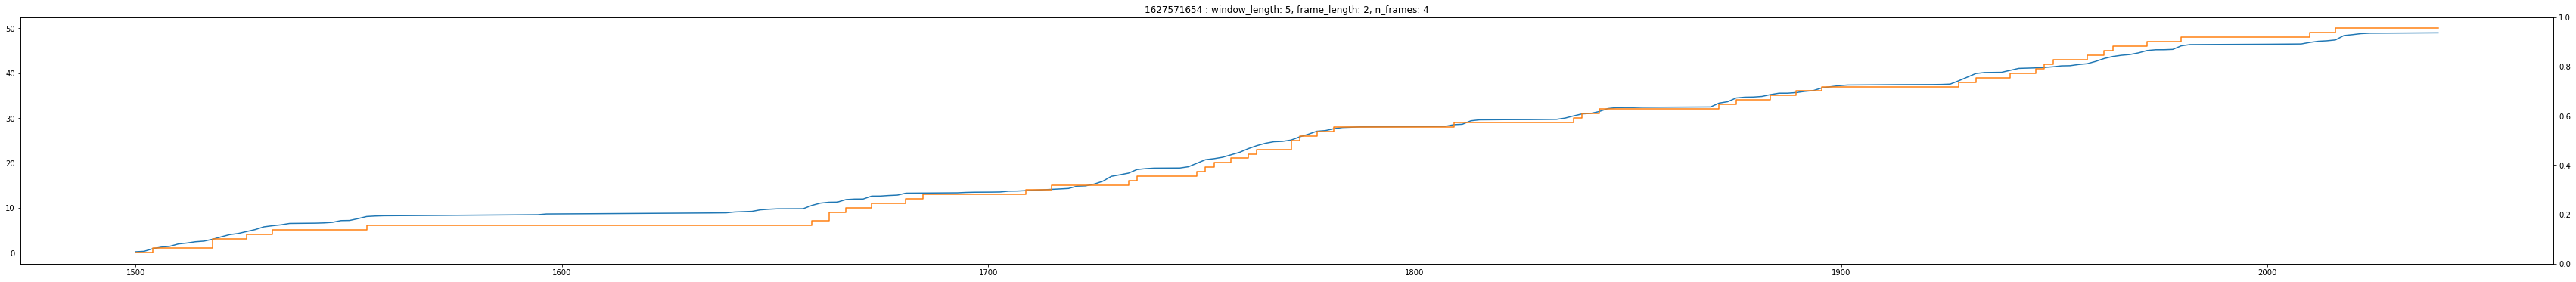

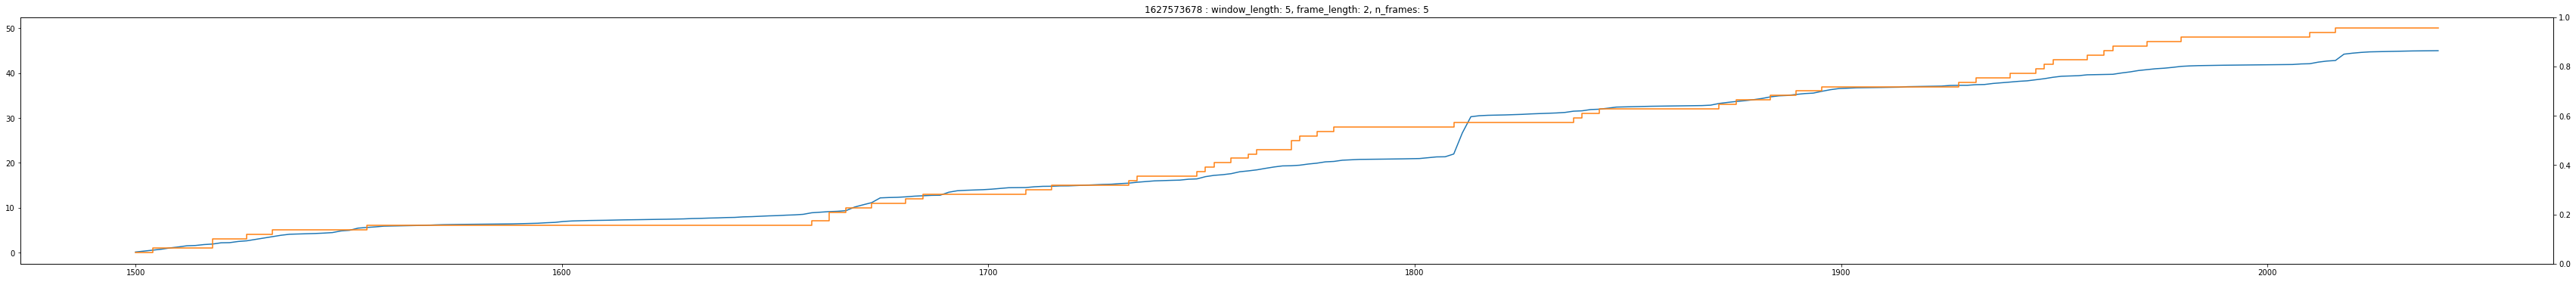

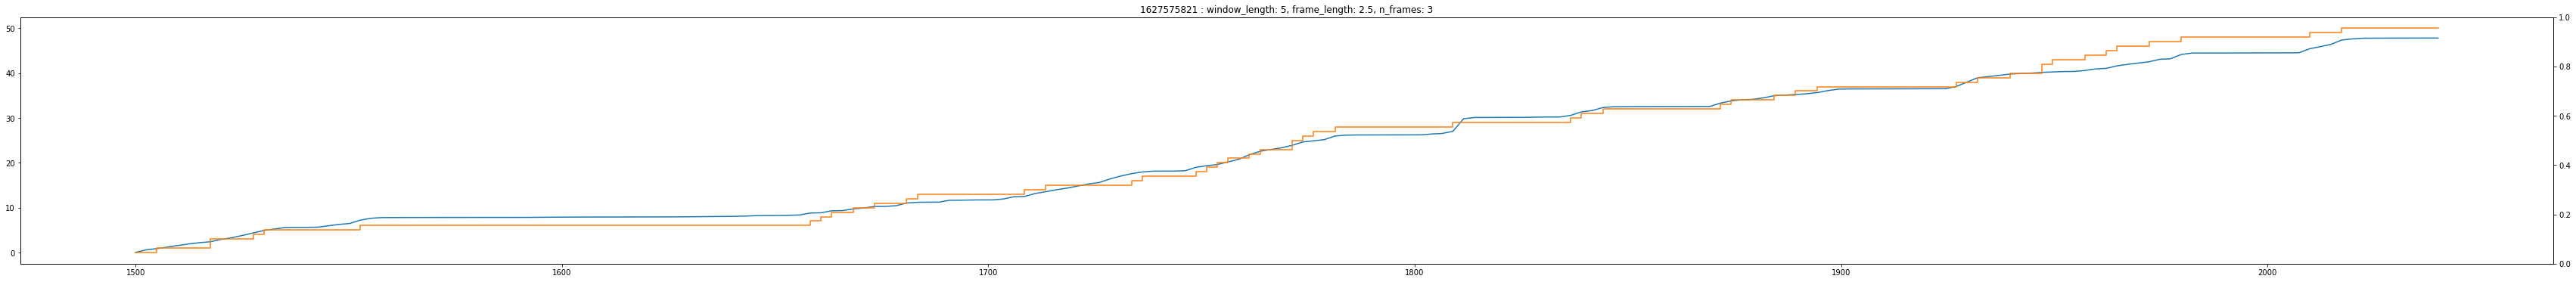

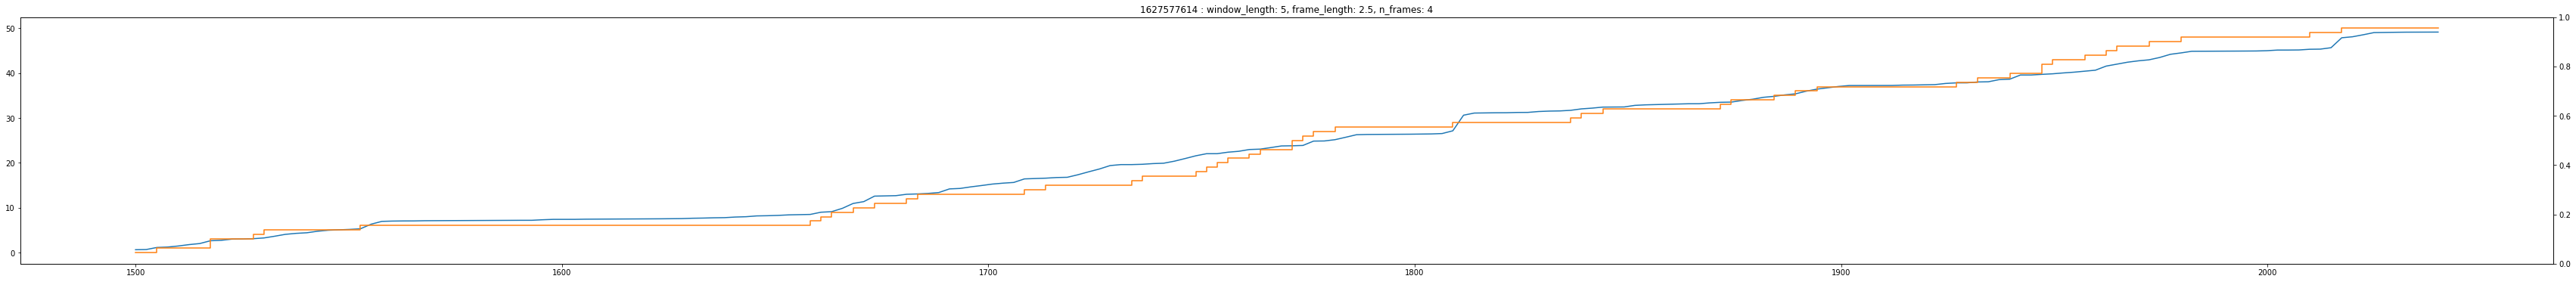

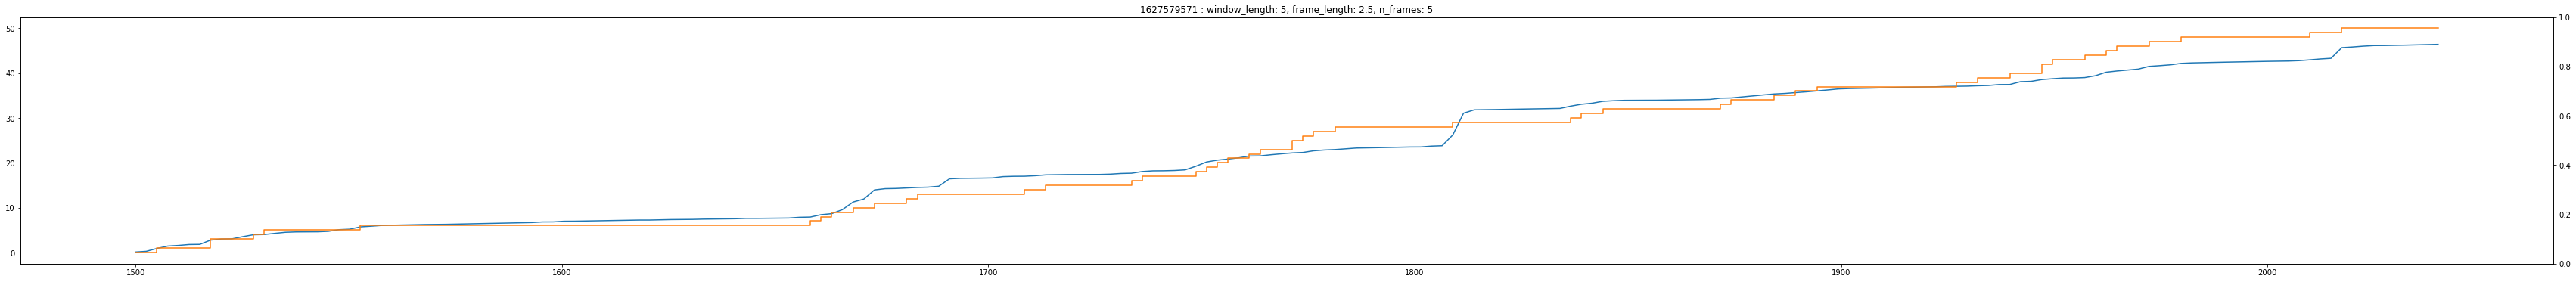

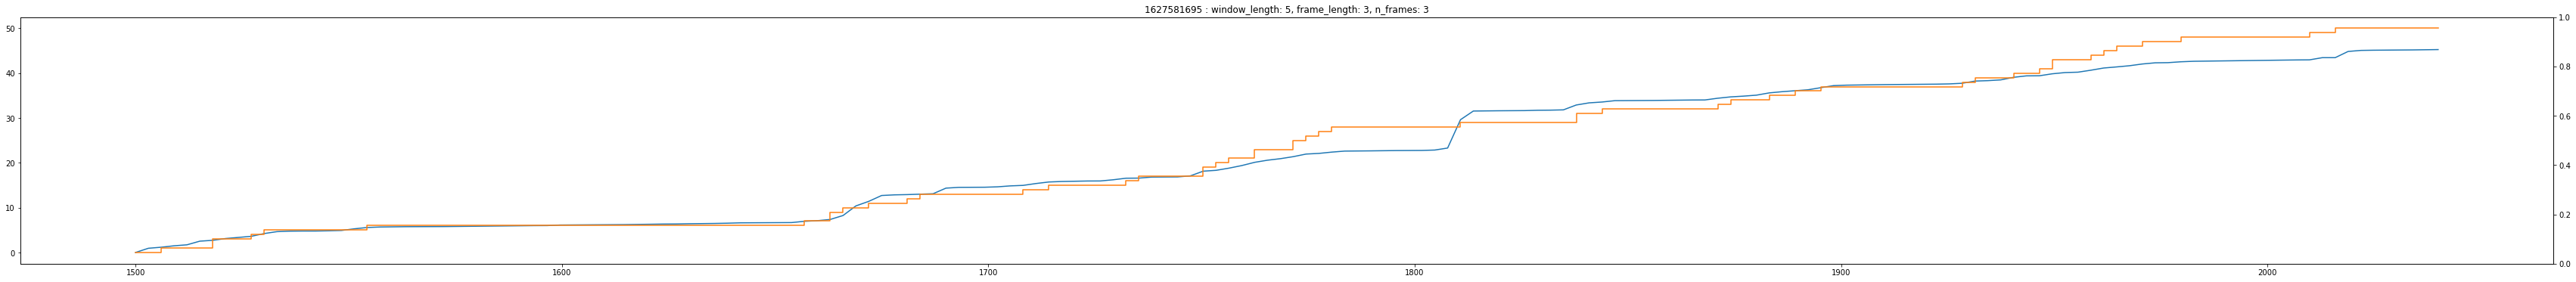

In [47]:
i = 0
for config in configs.values():
    test_model(config)
    i += 1
#     if i == 20:
#         break
#     cumsum = np.cumsum(results)